### check out worker commuting patterns by neighborhood from LODES data
+ when Data Facility get's data end point below can be updated to pull data from there

In [98]:
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt

import requests

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
# get blockgroup to neighborhood lookup
bg_to_nhoods = pd.read_csv('https://raw.githubusercontent.com/crusselsh/cusp-df-miscfiles/master/data/bg2010_lookup.csv')

# create as geodataframe
bg_to_nhoods['geometry'] = bg_to_nhoods.apply(lambda z: Point(z.lon, z.lat), axis=1)
bg_to_nhoods = gpd.GeoDataFrame(bg_to_nhoods)

In [16]:
# reproject data for later distance calculations
bg_to_nhoods.crs = {'init': 'epsg:4326'}
bg_to_nhoods.to_crs(epsg=2163, inplace=True) # reproject data to meters for later distance calculation
print bg_to_nhoods.crs

{'init': 'epsg:2163', 'no_defs': True}


In [17]:
bg_to_nhoods.head()

,geoid,ntacode,ntaname,lat,lon,geometry
0,360610146013,MN32,Yorkville,40.777350,-73.953593,POINT (2149316.58116256 -124434.1906061099)
1,360610317043,MN25,Battery Park City-Lower Manhattan,40.708966,-74.015986,POINT (2146670.852355168 -133417.1202490268)
2,360050235023,BX41,Mount Hope,40.851468,-73.903562,POINT (2150779.485511198 -115161.8446871856)
3,360050403041,BX28,Van Cortlandt Village,40.868126,-73.896181,POINT (2150801.761189202 -113180.0175900334)
4,360470508041,BK42,Flatbush,40.653663,-73.963896,POINT (2152642.955259461 -137977.0650131154)


In [3]:
# and NY LODES data for specified year and job type ('JT00' - 'JT05')
yr = 2013
jt = 'JT01'

# set import site
site = 'http://lehd.ces.census.gov/data/lodes/LODES7/ny/od/ny_od_main_%s_%s.csv.gz' % (jt, yr)

# download data and write to working folder - note file is ~390MB so takes a bit
r = requests.get(site, stream=True)
fname = site.split('/')[-1]
with open(fname, 'wb') as fd:
    for chunk in r.iter_content(1000):
        fd.write(chunk)

# read in data file
emp_od = pd.read_csv(fname)

emp_od.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,360010001001004,360010004032010,1,0,1,0,0,0,1,0,1,0,20150727
1,360010001001004,360010020005001,1,0,1,0,0,0,1,0,1,0,20150727
2,360010001001004,360010144012034,1,0,1,0,0,0,1,0,1,0,20150727
3,360010001001004,360210005001006,1,0,1,0,0,0,1,0,1,0,20150727
4,360010001001004,360830411001025,1,0,1,0,0,0,1,0,1,0,20150727


In [18]:
## grab only intra-NYC commuters

# first create blockgroup codes by cutting off last 3 digits of block codes
emp_od['h_geoid'], emp_od['w_geoid'] = emp_od.h_geocode / 1000, emp_od.w_geocode / 1000

# then join the bg<->nhood data to create O and D, drops missing eg outside NYC
O = pd.merge(emp_od, bg_to_nhoods, how='inner', left_on='h_geoid', right_on='geoid')
D = pd.merge(emp_od, bg_to_nhoods, how='inner', left_on='w_geoid', right_on='geoid')

# create column for joining
O['join_col'] = O.h_geocode.astype(str) + '_' + O.w_geocode.astype(str)
D['join_col'] = D.h_geocode.astype(str) + '_' + D.w_geocode.astype(str)

# drop columns that we don't want
D.drop(['S000', 'SA01', 'SA02', 'SA03', 'SE01', 'SE02', 
        'SE03', 'SI01', 'SI02', 'SI03', 'createdate', 'h_geoid', 'w_geoid', 'geoid', 'w_geocode', 'h_geocode'],
      axis=1, inplace=True)
O.drop(['createdate', 'geoid'], axis=1, inplace=True)

# and rename some columns
D.rename(columns={'ntacode': 'd_nta', 'ntaname': 'd_name', 'lat': 'd_lat', 
                  'lon': 'd_lon', 'geometry': 'd_geom'}, inplace=True)
O.rename(columns={'geometry': 'o_geom'}, inplace=True)

nyc_od = pd.merge(O, D, how='inner', left_on='join_col', right_on='join_col')
nyc_od.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150259 entries, 0 to 150258
Data columns (total 25 columns):
w_geocode    150259 non-null int64
h_geocode    150259 non-null int64
S000         150259 non-null int64
SA01         150259 non-null int64
SA02         150259 non-null int64
SA03         150259 non-null int64
SE01         150259 non-null int64
SE02         150259 non-null int64
SE03         150259 non-null int64
SI01         150259 non-null int64
SI02         150259 non-null int64
SI03         150259 non-null int64
h_geoid      150259 non-null float64
w_geoid      150259 non-null float64
ntacode      150259 non-null object
ntaname      150259 non-null object
lat          150259 non-null float64
lon          150259 non-null float64
o_geom       150259 non-null object
join_col     150259 non-null object
d_nta        150259 non-null object
d_name       150259 non-null object
d_lat        150259 non-null float64
d_lon        150259 non-null float64
d_geom       150259 non-null ob

In [22]:
# calculate distances
O_locs = gpd.GeoSeries(nyc_od.o_geom)
D_locs = gpd.GeoSeries(nyc_od.d_geom)

distances = O_locs.distance(D_locs)
len(distances)

150259

In [26]:
# check distance calc in postgres:
'''
in:
SELECT ST_Distance(
	ST_SetSRID(ST_POINT(2149113.373247273,-125499.1939747771), 2163),
	ST_SetSRID(ST_POINT(2156113.116943482, -115281.8824039682), 2163)
	) as d1,
	ST_Distance(
	ST_SetSRID(ST_POINT(2149113.373247273, -125499.1939747771), 2163),
	ST_SetSRID(ST_POINT(2155263.094041817, -113859.593690396), 2163)
	) as d2

out:
12385.0663117968 | 13164.3215028733
'''
print 'success'

success


In [27]:
nyc_od['dists_mts'] = distances

In [28]:
print nyc_od.columns.tolist()

['w_geocode', 'h_geocode', 'S000', 'SA01', 'SA02', 'SA03', 'SE01', 'SE02', 'SE03', 'SI01', 'SI02', 'SI03', 'h_geoid', 'w_geoid', 'ntacode', 'ntaname', 'lat', 'lon', 'o_geom', 'join_col', 'd_nta', 'd_name', 'd_lat', 'd_lon', 'd_geom', 'dists_mts']


In [75]:
# create neighborhood level distance summaries

nyc_od['se01wt'] = nyc_od.SE01 * nyc_od.dists_mts
nyc_od['se02wt'] = nyc_od.SE02 * nyc_od.dists_mts
nyc_od['se03wt'] = nyc_od.SE03 * nyc_od.dists_mts

res_grouped = nyc_od.groupby(['ntacode', 'ntaname'])

se01_wAvg = res_grouped.se01wt.sum() / res_grouped.SE01.sum()
se02_wAvg = res_grouped.se02wt.sum() / res_grouped.SE02.sum()
se03_wAvg = res_grouped.se03wt.sum() / res_grouped.SE03.sum()

dest_nhoods = res_grouped.d_nta.nunique()

nhood_earnings_distances = pd.DataFrame({'low_earn': res_grouped.SE01.sum(),
                                        'mid_earn': res_grouped.SE02.sum(),
                                        'high_earn': res_grouped.SE03.sum()})
nhood_earnings_distances['low_dist'] = se01_wAvg
nhood_earnings_distances['mid_dist'] = se02_wAvg
nhood_earnings_distances['high_dist']= se03_wAvg
nhood_earnings_distances['dest_nhoods'] = dest_nhoods
nhood_earnings_distances.head()

,,high_earn,low_earn,mid_earn,low_dist,mid_dist,high_dist,dest_nhoods
ntacode,ntaname,,,,,,,
BK09,Brooklyn Heights-Cobble Hill,430,82,104,8376.502399,7715.703119,7373.224096,90
BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,268,169,283,9311.099167,11021.664072,14986.847328,103
BK19,Brighton Beach,163,147,209,8225.143427,10078.173330,14547.693116,88
BK21,Seagate-Coney Island,144,179,275,11586.351561,12569.516440,17579.664061,102
BK23,West Brighton,294,194,367,9956.282182,11132.725674,14198.125704,99


In [65]:
nhood_earnings_distances.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 194 entries, (BK09, Brooklyn Heights-Cobble Hill) to (SI54, Great Kills)
Data columns (total 6 columns):
high_earn    194 non-null int64
low_earn     194 non-null int64
mid_earn     194 non-null int64
low_dist     193 non-null float64
mid_dist     194 non-null float64
high_dist    193 non-null float64
dtypes: float64(3), int64(3)
memory usage: 13.0+ KB


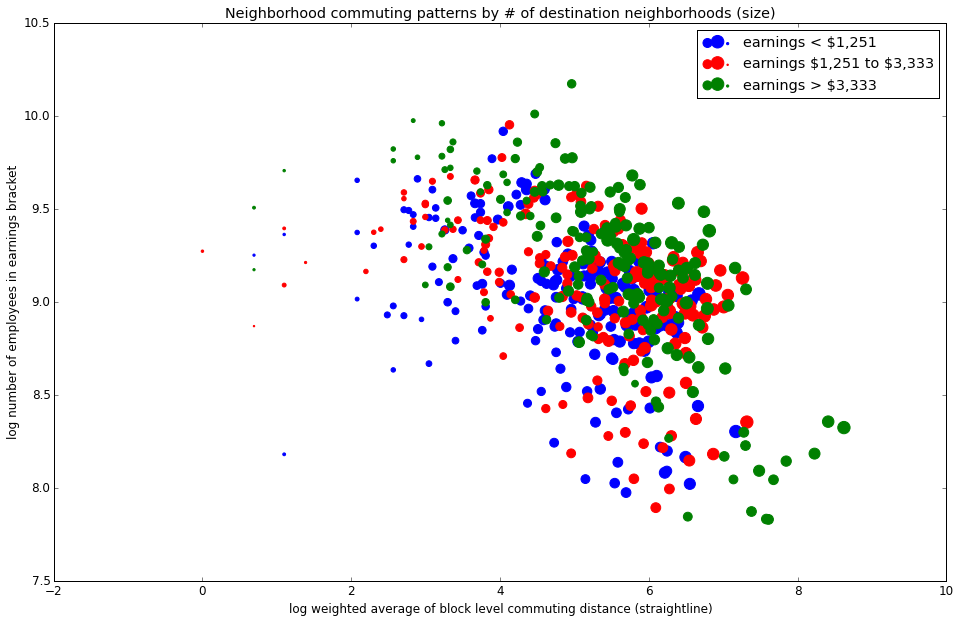

In [99]:
# plot x = distance, y = earnings for each of the 3 earning's groups
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(16,10))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('white')
ax.scatter(log(nhood_earnings_distances.low_earn), log(nhood_earnings_distances.low_dist), color='blue', 
               label='earnings < $1,251', s=nhood_earnings_distances.dest_nhoods)
#axM = fig.add_subplot(332)
ax.scatter(log(nhood_earnings_distances.mid_earn), log(nhood_earnings_distances.mid_dist), color='red', 
               label='earnings \$1,251 to $3,333', s=nhood_earnings_distances.dest_nhoods)
#axH = fig.add_subplot(333)
ax.scatter(log(nhood_earnings_distances.high_earn), log(nhood_earnings_distances.high_dist), color='g', 
               label='earnings > $3,333', s=nhood_earnings_distances.dest_nhoods)
ax.legend(loc='best')
#axM.legend(loc='best')
#axH.legend(loc='best')
ax.set_ylabel('log number of employees in earnings bracket')
ax.set_xlabel('log weighted average of block level commuting distance (straightline)')
ax.set_title('Neighborhood commuting patterns by # of destination neighborhoods (size)')
plt.savefig('nhood_commuting')